One approach for performing an overfitting analysis on algorithms that do not learn incrementally is by varying a key model hyperparameter and evaluating the model performance on the train and test sets for each configuration.

In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics

from seffaflik.elektrik import santraller, tuketim, uretim, yekdem

import warnings
warnings.filterwarnings('ignore')

In [3]:
# get Turkey's energy production dataset from epias
start_date = '2020-01-01'
end_date = '2021-01-01'
production = uretim.gerceklesen(start_date, end_date,)

In [4]:
production.head()

,Tarih,Saat,Doğalgaz,Barajlı,Linyit,Akarsu,İthal Kömür,Rüzgar,Güneş,Fuel Oil,Jeo Termal,Asfaltit Kömür,Taş Kömür,Biyokütle,Nafta,LNG,Uluslararası,Toplam
0,2020-01-01,0,6166.40,3761.62,5780.09,1545.26,7302.54,770.50,0.0,35.5,1157.82,293.65,572.31,396.65,0,0,278.0,28060.34
1,2020-01-01,1,5161.03,3079.97,5792.66,1548.51,7286.46,776.18,0.0,35.8,1164.57,273.78,575.65,392.46,0,0,394.0,26481.07
2,2020-01-01,2,5149.52,2160.79,5755.22,1460.39,7281.67,787.75,0.0,36.3,1167.74,273.78,585.67,390.22,0,0,172.0,25221.05
3,2020-01-01,3,3860.16,2292.47,5793.94,1591.92,7299.57,815.19,0.0,36.6,1168.91,271.57,569.56,392.99,0,0,154.0,24246.88
4,2020-01-01,4,3437.43,2470.96,5626.99,1653.69,7299.74,939.26,0.0,33.0,1167.93,273.78,374.90,401.09,0,0,-13.0,23665.77


In [5]:
production.describe()

,Saat,Doğalgaz,Barajlı,Linyit,Akarsu,İthal Kömür,Rüzgar,Güneş,Fuel Oil,Jeo Termal,Asfaltit Kömür,Taş Kömür,Biyokütle,Nafta,LNG,Uluslararası,Toplam
count,8808.00000,8808.000000,8808.000000,8808.000000,8808.000000,8808.000000,8808.000000,8808.000000,8808.000000,8808.000000,8808.000000,8808.000000,8808.000000,8808.0,8808.0,8808.000000,8808.000000
mean,11.50000,7746.026504,6515.794933,4303.827785,2331.419566,7111.608642,2788.028970,47.980268,35.631681,1061.087693,252.972661,431.470344,463.165296,0.0,0.0,-62.418569,33026.595775
std,6.92258,3952.323549,3171.403680,622.512318,1448.579504,1716.678584,1608.350955,66.317553,3.309019,105.220071,79.484606,158.347459,36.506329,0.0,0.0,315.830842,5495.008940
min,0.00000,496.660000,366.190000,2189.100000,419.440000,992.650000,139.760000,0.000000,0.000000,663.530000,48.570000,167.240000,369.680000,0.0,0.0,-1949.250000,15246.640000
25%,5.75000,3980.625000,3902.125000,3921.495000,1090.195000,6708.195000,1370.720000,0.000000,34.200000,993.385000,211.960000,272.177500,439.615000,0.0,0.0,-313.360000,29067.472500
50%,11.50000,8929.805000,6796.245000,4305.005000,1809.795000,7656.220000,2588.285000,2.670000,36.400000,1089.000000,242.880000,438.840000,458.440000,0.0,0.0,-85.000000,32908.105000
75%,17.25000,11058.337500,9052.125000,4732.692500,3552.550000,8340.122500,4092.695000,93.282500,37.800000,1141.867500,333.390000,598.862500,480.445000,0.0,0.0,182.000000,37484.857500
max,23.00000,14615.630000,15891.780000,6149.070000,5744.500000,8790.980000,6861.040000,297.990000,43.600000,1255.580000,362.100000,692.620000,596.090000,0.0,0.0,789.000000,45210.030000


In [6]:
production.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8808 entries, 0 to 8807
Data columns (total 18 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Tarih           8808 non-null   datetime64[ns]
 1   Saat            8808 non-null   int64         
 2   Doğalgaz        8808 non-null   float64       
 3   Barajlı         8808 non-null   float64       
 4   Linyit          8808 non-null   float64       
 5   Akarsu          8808 non-null   float64       
 6   İthal Kömür     8808 non-null   float64       
 7   Rüzgar          8808 non-null   float64       
 8   Güneş           8808 non-null   float64       
 9   Fuel Oil        8808 non-null   float64       
 10  Jeo Termal      8808 non-null   float64       
 11  Asfaltit Kömür  8808 non-null   float64       
 12  Taş Kömür       8808 non-null   float64       
 13  Biyokütle       8808 non-null   float64       
 14  Nafta           8808 non-null   int64         
 15  LNG      

In [8]:
feature_cols = [col for col in production.columns if col not in ['Toplam', 'Tarih', 'Saat',
                                                                 'Nafta', 'LNG']]

pred_col = ['Toplam']

X = production[feature_cols]
y = production[pred_col]

y = y.where(y<y.mean(), 1)
y = y.where(y==1, 0)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0, shuffle=True)

In [11]:
model = DecisionTreeClassifier()
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=0)
n_scores = cross_val_score(model, X_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1)

In [13]:
n_scores.mean(), n_scores.std()

(0.947068011674981, 0.008968950116700188)

In [16]:
# gridcv changin tree depth
params = {
    'max_depth': np.arange(1, 21)
}

grid = GridSearchCV(model, param_grid=params, scoring='accuracy', n_jobs=-1, cv=cv)
n_scores = grid.fit(X_train, y_train)

In [18]:
n_scores.best_params_

{'max_depth': 10}

In [26]:
train_scores = []
test_scores = []
values = [i for i in range(1, 21)]

for i in values:
    
    model = DecisionTreeClassifier(max_depth=i)
    model.fit(X_train, y_train)
    
    train_yhat = model.predict(X_train)
    train_acc = metrics.accuracy_score(y_train, train_yhat)
    train_scores.append(train_acc)
    
    test_yhat = model.predict(X_test)    
    test_acc = metrics.accuracy_score(y_test, test_yhat)
    test_scores.append(test_acc)
    
    print(i, train_acc, test_acc)

1 0.7454987834549879 0.7275822928490352
2 0.8828872668288726 0.8675747256905032
3 0.8986212489862125 0.8910329171396141
4 0.9219789132197891 0.9035187287173666
5 0.943227899432279 0.9190314037079077
6 0.964639091646391 0.936057510404843
7 0.972911597729116 0.93946273174423
8 0.986536901865369 0.9417328793038214
9 0.9930251419302514 0.9424895951570186
10 0.997080291970803 0.9413545213772229
11 0.9988645579886456 0.9440030268634128
12 1.0 0.9409761634506243
13 1.0 0.9451381006432085
14 1.0 0.9424895951570186
15 1.0 0.9424895951570186
16 1.0 0.9436246689368142
17 1.0 0.9436246689368142
18 1.0 0.9436246689368142
19 1.0 0.9440030268634128
20 1.0 0.9451381006432085


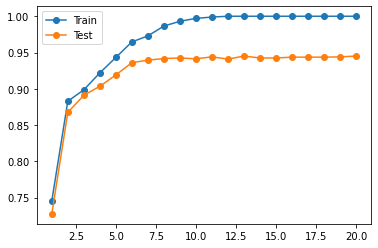

In [27]:
# plot of train and test scores vs tree depth
plt.plot(params['max_depth'], train_scores, '-o', label='Train')
plt.plot(params['max_depth'], test_scores, '-o', label='Test')
plt.legend()
plt.show()

In [30]:
train_scores = []
test_scores = []
values = [i for i in range(1, 50)]

for i in values:
    
    model = KNeighborsClassifier(n_neighbors=i)
    model.fit(X_train, y_train)
    
    train_yhat = model.predict(X_train)
    train_acc = metrics.accuracy_score(y_train, train_yhat)
    train_scores.append(train_acc)
    
    test_yhat = model.predict(X_test)    
    test_acc = metrics.accuracy_score(y_test, test_yhat)
    test_scores.append(test_acc)
    
    print(i, train_acc, test_acc)

1 1.0 0.9693530079455165
2 0.9870235198702352 0.9670828603859251
3 0.9881589618815896 0.9701097237987136
4 0.9834549878345499 0.9670828603859251
5 0.9842660178426602 0.9701097237987136
6 0.9818329278183293 0.9678395762391222
7 0.9816707218167072 0.9716231555051078
8 0.9798864557988646 0.9689746500189179
9 0.9790754257907542 0.9716231555051078
10 0.9792376317923763 0.9720015134317064
11 0.9787510137875102 0.9738933030646992
12 0.978426601784266 0.972379871358305
13 0.9792376317923763 0.972379871358305
14 0.9777777777777777 0.9712447975785092
15 0.978426601784266 0.9689746500189179
16 0.9774533657745337 0.9708664396519107
17 0.9777777777777777 0.9708664396519107
18 0.9766423357664233 0.9693530079455165
19 0.9771289537712895 0.9701097237987136
20 0.9748580697485807 0.9701097237987136
21 0.9771289537712895 0.9701097237987136
22 0.9753446877534468 0.9693530079455165
23 0.9764801297648013 0.9689746500189179
24 0.9751824817518249 0.9693530079455165
25 0.9746958637469586 0.9708664396519107
26 

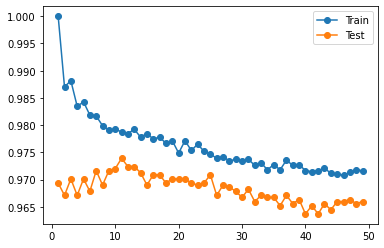

In [36]:
# plot of train and test scores vs tree depth
plt.plot(values, train_scores, '-o', label='Train')
plt.plot(values, test_scores, '-o', label='Test')
plt.legend()
plt.show()